## Topic Modeling for Libraray Dialouges

In [2]:
#some library imports
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import pandas as pd
import os

In [3]:
# load the file
df = pd.read_csv("./data/all_chats_0330_startlineFalse.csv")
logs = df["chat"]

### The number of dialouge sessions up to date

In [4]:
len(logs)

741

### Data Class with user and lib utters and add_from_log function

In [5]:
class ChatData():
    
    def __init__(self, user_utters = None, lib_utters = None):
        
        if user_utters:
            self.user_utters = user_utters
            
        else:
            self.user_utters = []
            
        if lib_utters:
            self.lib_utters = lib_utters
            
        else:
            self.lib_utters = []
            
    def add_from_log(self, log, show_errors = False):
    # take a log and split the log into lines and add the utterences according to role    
        assert type(log) == str, "Wrong type of log, should be type of str"
        
        error_logs = []

        lines = log.split("\n")
        for line in lines:
            line_splitted = line.split(" ")
            if len(line_splitted) > 1:
                role, utter = line_splitted[0].strip(), " ".join(line_splitted[1:]).strip()
                if role == "<user>":
                    self.user_utters.append(utter)
                elif role =="<librarian>":
                    self.lib_utters.append(utter)
                else:
                    pass
            else:
                error_logs.append(line)
        if show_errors:
            print("Fllowing utterances are not added")
            print(error_logs)
            

In [6]:
data = ChatData()
for log in logs:
    data.add_from_log(log)
user_utters = data.user_utters
lib_utters = data.lib_utters
# filter all the invalid lines(with len == 0)
user_utters = [utter for utter in user_utters if len(utter)>0]
lib_utters = [utter for utter in lib_utters if len(utter)>0]

In [7]:
# data to feed the models
user_data = pd.DataFrame(user_utters)[0]
lib_data = pd.DataFrame(lib_utters)[0]

In [8]:
total_data = user_data+lib_data[0]

#### Exploratory Analysis

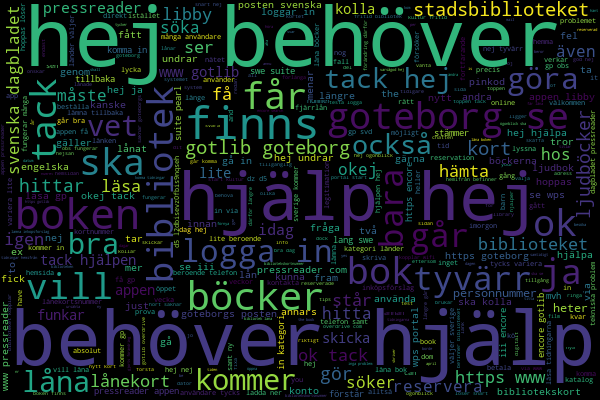

In [9]:
from wordcloud import WordCloud

stopwords = nltk.corpus.stopwords.words("swedish")

# Join the different processed titles together.
long_string1 = ','.join(list(user_utters))
long_string2 = ",".join(list(lib_utters))

# Create a WordCloud object
wordcloud = WordCloud(stopwords=stopwords,background_color="black", width=600,
                        height=400,max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string1+long_string2)

# Visualize the word cloud
wordcloud.to_image()

In [10]:
stopwords_extra = ["librarian","user","hej","in", "tack", "ok","bok", "behöver", "hjälp","hjälpen"]
stopwords = stopwords + stopwords_extra

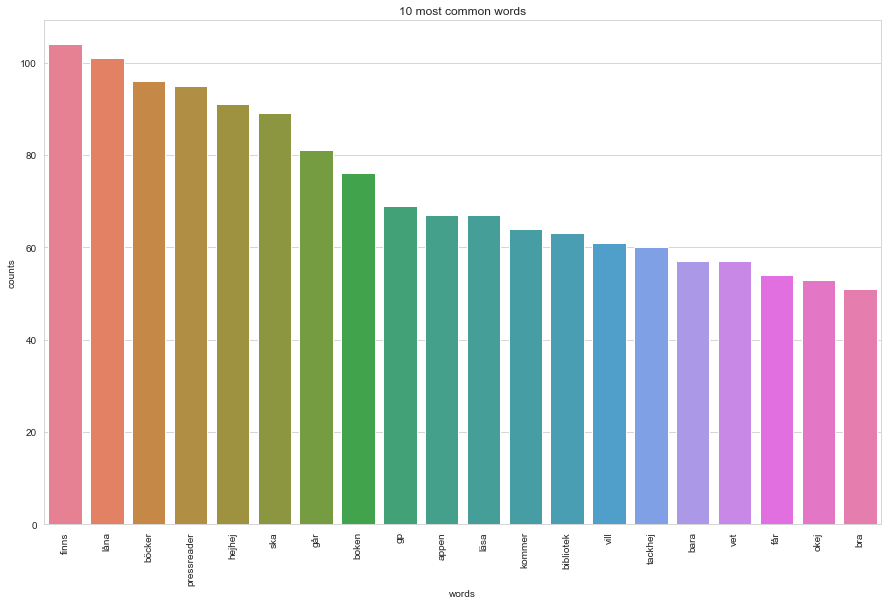

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the Swedish stop words
count_vectorizer = CountVectorizer(stop_words=stopwords)

# Fit and transform the processed utters
count_data = count_vectorizer.fit_transform(total_data)

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

# Initialise the tfidf vectorizer with the Swedish stop words
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords)

# Fit and transform the processed utters
tfidf_data = tfidf_vectorizer.fit_transform(logs)

### LDA
#### Remark: Change the number of topics and number of words yielded for each topic below

In [18]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 10
number_words = 20

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics founds via LDA-TM:")
print_topics(lda, count_vectorizer, number_words)

Topics founds via LDA-TM:

Topic #0:
vill boka logga går ljudböcker se ta bra göteborg försöker kommer funkar grupprum hämta fungerar pressreader appenhej dom får boken

Topic #1:
låna ska bokhej personnummer dagbladet gång pinkod bibliotek testar svenska nästa glömt finns kommer logga ljudböcker lånekort går hittar få

Topic #2:
bra vet pressreaderhej lyssna jaghej förstår se använder böcker daghej myckethej undrar söker barn bara dag ex boken app japp

Topic #3:
pressreader gp läsa längre appen finns lånekort aftonbladet svd går kommer låna bara ska undrar via vet tidningar logga problem

Topic #4:
göra svar hjälpenhej stadsbiblioteket ska snabbt finns boken svenska bara fjärrlån veta söker fått står möjligt bibliotek vilja hittar åh

Topic #5:
hejhej ja låna appen verkar gör göteborgs går får bibliotek ljudböcker via vet nej nuhej just öppet böcker biblioteket tillgänglig

Topic #6:
to it the you can hittar have is do ner finns thank hitta böcker book bibliotek bara status hämta sta

### Some help and visulasation for topic modeling analysis
#### Remark: adjust the value of λ to better filter out not topic specific words

In [19]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [20]:
lda_tf = LDA(n_components=10,random_state=0)
lda_tf.fit(count_data)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [21]:
pyLDAvis.sklearn.prepare(lda_tf, count_data, count_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.120762 -0.155773       1        1  14.493179
3      0.066144 -0.024358       2        1  12.061521
7     -0.183546 -0.102600       3        1  11.573597
9      0.072818  0.091930       4        1  10.139447
0     -0.069456  0.097939       5        1   9.971502
8     -0.015821  0.048281       6        1   9.614113
6      0.023872  0.007882       7        1   9.342182
5      0.042306  0.040818       8        1   8.655535
1     -0.042473 -0.017502       9        1   7.570388
4     -0.014607  0.013383      10        1   6.578536, topic_info=             Term       Freq      Total Category  logprob  loglift
1263       hejhej  68.000000  68.000000  Default  30.0000  30.0000
2995      tackhej  44.000000  44.000000  Default  29.0000  29.0000
1175           gp  54.000000  54.000000  Default  28.0000  28.0000
2432  pressreader  75.000000  75.000000  Default  27.0000  27.0000
514           bra  38.000000  38.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
3323        vilja   2.145804  16.192760  Topic10  -5.7571   0.7003
1032           få   2.145800  31.347246  Topic10  -5.7571   0.0397
1307        heter   2.145786  18.702944  Topic10  -5.7571   0.5562
1224     göteborg   2.145780  14.009428  Topic10  -5.7571   0.8451
401   biblioteket   2.145774  27.773618  Topic10  -5.7571   0.1608

[659 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
10        9  0.920875           031
71        5  0.900548            26
73        8  0.682126           27e
82        2  0.187707         300m2
82        3  0.563122         300m2
...     ...       ...           ...
3456      8  0.168993            åh
3465      6  0.902054    återkommer
3481      5  0.900548  ögonblickhej
3489      8  0.682126        önskat
3491      2  0.880229         öppen

[1290 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 8, 10, 1, 9, 7, 6, 2, 5])